In [2]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/bookcrossing'

In [3]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [4]:
[df, df_train,df_valid,df,df_ratings,dfflagtrain,dfflagvalid,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

In [5]:
df_ratings=df.pivot(index='movieId',columns='userId',values='rating')
df_ratings.fillna(0,inplace=True)

In [6]:
dfflagtrain=df.pivot(index='movieId',columns='userId',values='dstype_random_train')
dfflagtrain.head()
dfflagtrain.fillna(0,inplace=True)
df_train=df_ratings*dfflagtrain

In [7]:
dfflagvalid=df.pivot(index='movieId',columns='userId',values='dstype_random_valid')
dfflagvalid.head()
dfflagvalid.fillna(0,inplace=True)
df_valid=df_ratings*dfflagvalid

## Dataset and DataLoader

In [8]:
class autoencdata (Dataset):
    def __init__(self,dfX,dfXv):
        self.dfX,self.dfXv=dfX,dfXv
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor(self.dfXv.iloc[idx].values)

In [9]:
dstrain=autoencdata(df_train, df_valid)
#dsvalid=autoencdata(df_valid)

In [10]:
bs=64

In [11]:
# Create a DataLoader object
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=False)
#dlvalid=DataLoader(dsvalid,batch_size=bs,shuffle=False) 

In [12]:
df['rating'].min(),df['rating'].max()

(0.5, 5.0)

In [13]:
df_train.shape

(9724, 610)

In [14]:
len(dltrain)

152

## Create the Model Architecture for the Encoder

In [15]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [16]:
class autoencoder (nn.Module):    
    def __init__(self,n_inp,hidden=[50,10],dropouts=[0,0,0],rating_range=[0.5,5]):
        super().__init__()
        self.n_inp,self.hidden,self.dropouts,self.rating_range=n_inp,hidden,dropouts,rating_range
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i],\
                              nn.Sigmoid() if i<len(hidden)-1 else nn.Tanh()) for i in range(len(hidden))]
        self.encoder=nn.Sequential(*encoder)
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<len(hidden)-1 else n_inp,dropouts[i]) for i in range(len(hidden)-1)]
        self.decoder=nn.Sequential(*decoder)
        self.fc=nn.Linear(hidden[-1],n_inp)
        self.initialize()
        self.criterion=nn.MSELoss()
    
    def initialize(self):
        for x in self.encoder:
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self,Xb):
        
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        outv=out.clone()
        out[Xb==0]=0
        loss=self.criterion(out,Xb)
        return outv,loss, out

In [20]:
autoenc=autoencoder(df_train.shape[1],[50,10],[0,0,0])

In [21]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=610, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
  )
  (fc): Linear(in_features=50, out_features=610, bias=True)
  (criterion): MSELoss()
)

In [22]:
for Xb, Xb_v in dltrain:
    print (Xb)
    break

tensor([[4.0000, 0.0000, 0.0000,  ..., 2.5000, 3.0000, 5.0000],
        [0.0000, 0.0000, 0.0000,  ..., 2.0000, 0.0000, 0.0000],
        [4.0000, 0.0000, 0.0000,  ..., 2.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.0000, 0.0000, 0.0000,  ..., 3.0000, 0.0000, 4.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [23]:
Xb.size()

torch.Size([64, 610])

In [24]:
Xb.squeeze(0)

tensor([[4.0000, 0.0000, 0.0000,  ..., 2.5000, 3.0000, 5.0000],
        [0.0000, 0.0000, 0.0000,  ..., 2.0000, 0.0000, 0.0000],
        [4.0000, 0.0000, 0.0000,  ..., 2.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.0000, 0.0000, 0.0000,  ..., 3.0000, 0.0000, 4.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [25]:
preds,loss,preds_train=autoenc.forward(Xb)

In [26]:
loss.backward()

In [27]:
preds.size()

torch.Size([64, 610])

In [28]:
nn.MSELoss

torch.nn.modules.loss.MSELoss

In [29]:
device="cuda:0"

In [30]:
wd=1e-4
#wd=1e-1

In [31]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
#optimizer=torch.optim.SGD(model_sentiment.parameters(),lr=1e-2,momentum=0.9, weight_decay=wd)
metric_fn=None

In [32]:
len(dltrain)

152

In [33]:
import matplotlib.pyplot as plt

In [34]:
dltrain.batch_size

64

In [35]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Xb_v,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss,preds_train=self.model(Xb)
        # denominator is the average of the error with non-zero ratings

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)
        mean_corrector_v = Xb_v.size(0)*Xb_v.size(1)/(torch.sum(Xb_v > 0).float() + 1e-10)

        with torch.no_grad():
            
            preds[Xb_v==0]=0
            loss_v=self.model.criterion(preds,Xb_v)
            
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
                acc_v=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=torch.sqrt(loss.item()*mean_corrector)
        myloss_v=torch.sqrt(loss_v.item()*mean_corrector_v)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc,myloss_v,acc_v
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_loss_v,epoch_acc_v=0,0

        for Xb,Xb_v in iterator:
            Xb=Xb.to(self.device)
            Xb_v=Xb_v.to(self.device)
            #Xb=Xb.squeeze(0)
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc,loss_v,acc_v=self.fit(Xb,Xb_v,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            epoch_loss_v+=loss_v
            epoch_acc_v+=acc_v
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)} {epoch_loss_v/(k)} ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_loss_v=epoch_loss_v/len(iterator)
        epoch_acc_v=epoch_acc_v/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_loss_v,epoch_acc_v
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        
        
            
        
        for epoch in range(n_epochs):                

            loss,acc,lossv,accv=self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Valid Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [36]:
autoenc=autoencoder(df_train.shape[1],[20,10],[0.6,0.6,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0)

In [37]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=610, out_features=20, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.6)
    )
    (1): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.6)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=20, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.6)
    )
  )
  (fc): Linear(in_features=20, out_features=610, bias=True)
  (criterion): MSELoss()
)

In [38]:
len(dltrain)

152

In [39]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

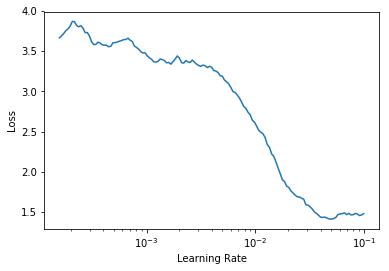

In [40]:
learner.plot_lrs(10)

In [41]:
autoenc=autoencoder(df_train.shape[1],[50,10],[0.25,0.25,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=3e-2,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=3e-2,end_lr=5e-4)

In [42]:
learner.run_epochs(dltrain,None,31)

Epoch:0 Learning rate 0.03 Weight Decay 1e-07 Train Loss:1.1256771087646484  Valid Loss:1.1222153902053833 
Epoch:1 Learning rate 0.0038729833462074164 Weight Decay 1e-07 Train Loss:1.0362846851348877  Valid Loss:1.0515596866607666 
Epoch:2 Learning rate 0.0004999999999999999 Weight Decay 1e-07 Train Loss:1.0025014877319336  Valid Loss:1.0095690488815308 
Epoch:3 Learning rate 0.03 Weight Decay 1e-07 Train Loss:1.0615040063858032  Valid Loss:1.047692060470581 
Epoch:4 Learning rate 0.010779123358892525 Weight Decay 1e-07 Train Loss:1.0138691663742065  Valid Loss:1.019904613494873 
Epoch:5 Learning rate 0.003872983346207416 Weight Decay 1e-07 Train Loss:0.9861228466033936  Valid Loss:0.9929802417755127 
Epoch:6 Learning rate 0.0013915788418568699 Weight Decay 1e-07 Train Loss:0.9590675234794617  Valid Loss:0.9723959565162659 
Epoch:7 Learning rate 0.0004999999999999998 Weight Decay 1e-07 Train Loss:0.9516915678977966  Valid Loss:0.9676387310028076 
Epoch:8 Learning rate 0.03 Weight Deca

In [39]:
autoenc=autoencoder(df_train.shape[1],[50,10],[0.25,0.25,0]).to(device)
wd=1e-6
optimizer=torch.optim.Adam(autoenc.parameters(),lr=3e-2,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=3e-2,end_lr=5e-4)

In [40]:
learner.run_epochs(dltrain,None,63)

Epoch:0 Learning rate 0.03 Weight Decay 1e-06 Train Loss:1.1154147386550903  Valid Loss:1.1090707778930664 
Epoch:1 Learning rate 0.03 Weight Decay 1e-06 Train Loss:1.0651289224624634  Valid Loss:1.0716365575790405 
Epoch:2 Learning rate 0.03 Weight Decay 1e-06 Train Loss:1.0455708503723145  Valid Loss:1.0405569076538086 
Epoch:3 Learning rate 0.03 Weight Decay 1e-06 Train Loss:1.0457130670547485  Valid Loss:1.0526307821273804 
Epoch:4 Learning rate 0.03 Weight Decay 1e-06 Train Loss:0.9965183138847351  Valid Loss:0.9932098388671875 
Epoch:5 Learning rate 0.03 Weight Decay 1e-06 Train Loss:0.971077561378479  Valid Loss:0.9727636575698853 
Epoch:6 Learning rate 0.03 Weight Decay 1e-06 Train Loss:0.9555948972702026  Valid Loss:0.9613544940948486 
Epoch:7 Learning rate 0.03 Weight Decay 1e-06 Train Loss:0.9592391848564148  Valid Loss:0.9557958245277405 
Epoch:8 Learning rate 0.03 Weight Decay 1e-06 Train Loss:0.94159334897995  Valid Loss:0.9423127770423889 
Epoch:9 Learning rate 0.03 Weig

In [43]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [44]:
item_mtx_1_weights.shape, item_mtx_2_weights.shape

((50, 610), (10, 50))

In [45]:
df_train.shape

(9724, 610)

In [46]:
from scipy.special import expit

df_train_item_autoenc=np.tanh(expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T)
df_valid_item_autoenc=np.tanh(expit(df_valid@item_mtx_1_weights.T)@item_mtx_2_weights.T)

In [47]:
df_train_item_autoenc=expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T
df_valid_item_autoenc=expit(df_valid@item_mtx_1_weights.T)@item_mtx_2_weights.T

In [48]:
df_train_item_autoenc.shape

(9724, 10)

In [49]:
df_valid_item_autoenc.shape

(9724, 10)

In [50]:
df_train.shape, df_valid.shape

((9724, 610), (9724, 610))

In [51]:
autoenc.encoder[0][0].weight.data.shape

torch.Size([50, 610])

In [52]:
autoenc.encoder[1][0].weight.data.shape

torch.Size([10, 50])

In [53]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [54]:
df_train_item_autoenc.columns=['item_autoenc'+str(i) for i in range(df_train_item_autoenc.shape[1])]

In [55]:
df_valid_item_autoenc.columns=['item_autoenc'+str(i) for i in range(df_valid_item_autoenc.shape[1])]

In [56]:
df_train_item_autoenc.reset_index(inplace=True)

In [57]:
df_valid_item_autoenc.reset_index(inplace=True)

In [58]:
import pickle
pickle.dump([df_train_item_autoenc, df_valid_item_autoenc,item_mtx_1_weights,item_mtx_2_weights],open(f'{DATAPATH}/inter/item_autoenc_weights.pkl','wb'))